In [1]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
import os

Loading YOLO model...

image 1/1 /home/praneeth/Desktop/eye_pop_assignment/ep-sai-praneeth-potladurthy/data/images/067f996eb808772c80004dea43a9c38f_image_cover_640.jpeg: 640x640 6 roofs, 490.0ms
Speed: 3.0ms preprocess, 490.0ms inference, 9.3ms postprocess per image at shape (1, 3, 640, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: ultralytics.engine.results.Masks object
names: {0: 'roof'}
obb: None
orig_img: array([[[ 38,  50,  38],
        [ 44,  58,  46],
        [ 61,  75,  63],
        ...,
        [146, 121, 101],
        [145, 118, 104],
        [145, 119, 107]],

       [[ 58,  67,  57],
        [ 62,  74,  62],
        [ 69,  83,  71],
        ...,
        [145, 120, 100],
        [141, 116, 100],
        [143, 117, 103]],

       [[ 84,  91,  84],
        [ 86,  94,  84],
        [ 80,  89,  79],
        ...,
        [147, 122, 102],
        [145, 121, 103],
        [146, 124, 106]],

  

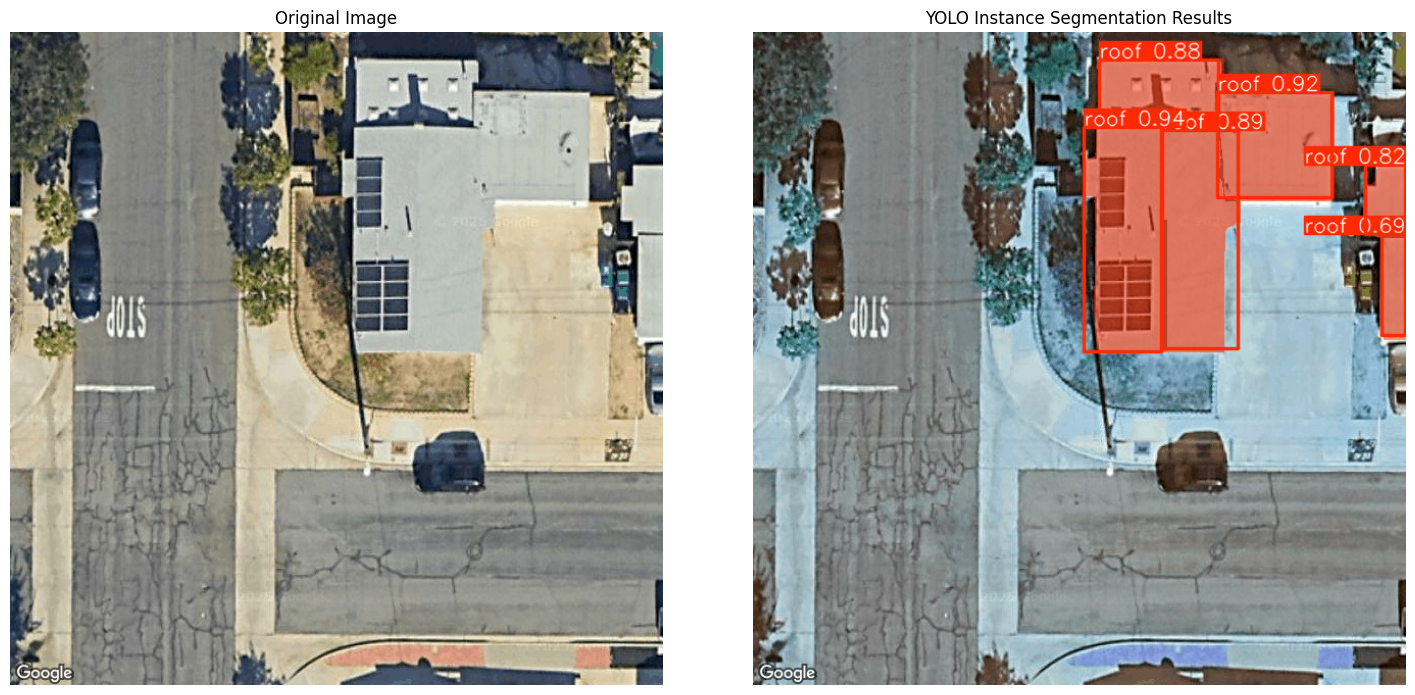

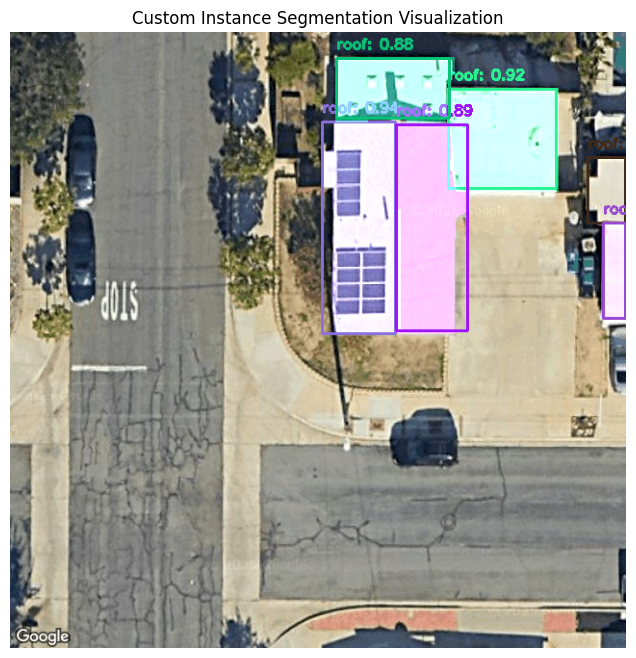

Results saved as 'segmentation_result.jpg'


In [3]:
def load_yolo_model(model_path='yolov8n-seg.pt'):
    """Load YOLO segmentation model"""
    model = YOLO(model_path)
    return model

def process_image_with_yolo(model, image_path):
    """Process image with YOLO and return results"""
    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Run inference
    results = model(image_path)
    print(results)
    
    return image_rgb, results

def visualize_results(image, results):
    """Visualize YOLO segmentation results"""
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Annotated image
    annotated_image = results[0].plot()
    axes[1].imshow(annotated_image)
    axes[1].set_title('YOLO Instance Segmentation Results')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

def print_yolo_results(results):
    """Print detailed YOLO results"""
    print("=== YOLO Model Results ===")
    
    for i, result in enumerate(results):
        print(f"\nImage {i + 1}:")
        print(f"Image shape: {result.orig_shape}")
        
        # Boxes information
        if result.boxes is not None:
            boxes = result.boxes
            print(f"Number of detections: {len(boxes)}")
            
            for j, box in enumerate(boxes):
                print(f"\nDetection {j + 1}:")
                print(f"  Bounding box (xyxy): {box.xyxy[0].cpu().numpy()}")
                print(f"  Confidence: {box.conf[0].cpu().numpy():.4f}")
                print(f"  Class ID: {int(box.cls[0].cpu().numpy())}")
                print(f"  Class name: {result.names[int(box.cls[0].cpu().numpy())]}")
        
        # Masks information
        if result.masks is not None:
            masks = result.masks
            print(f"\nSegmentation masks:")
            print(f"  Number of masks: {len(masks.data)}")
            print(f"  Mask shape: {masks.data[0].shape}")
            
            # Print mask statistics for each detection
            for j, mask in enumerate(masks.data):
                mask_np = mask.cpu().numpy()
                print(f"  Mask {j + 1}:")
                print(f"    Mask area (pixels): {np.sum(mask_np)}")
                print(f"    Mask coverage: {np.sum(mask_np) / mask_np.size * 100:.2f}%")

def draw_custom_visualization(image, results):
    """Create custom visualization with different colors for each instance"""
    # Create a copy of the original image
    vis_image = image.copy()
    
    if results[0].masks is not None:
        masks = results[0].masks.data.cpu().numpy()
        boxes = results[0].boxes
        
        # Generate random colors for each instance
        colors = np.random.randint(0, 255, size=(len(masks), 3))
        
        # Create overlay for masks
        overlay = vis_image.copy()
        
        for i, (mask, color) in enumerate(zip(masks, colors)):
            # Resize mask to image size
            mask_resized = cv2.resize(mask, (vis_image.shape[1], vis_image.shape[0]))
            
            # Apply color to mask areas
            colored_mask = np.zeros_like(vis_image)
            colored_mask[mask_resized > 0.5] = color
            
            # Blend with overlay
            overlay = cv2.addWeighted(overlay, 1, colored_mask, 0.5, 0)
            
            # Add bounding box and label
            if boxes is not None:
                box = boxes.xyxy[i].cpu().numpy()
                class_name = results[0].names[int(boxes.cls[i].cpu().numpy())]
                confidence = boxes.conf[i].cpu().numpy()
                
                # Draw bounding box
                cv2.rectangle(overlay, 
                            (int(box[0]), int(box[1])), 
                            (int(box[2]), int(box[3])), 
                            color.tolist(), 2)
                
                # Add label
                label = f"{class_name}: {confidence:.2f}"
                cv2.putText(overlay, label, 
                          (int(box[0]), int(box[1]) - 10),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, 
                          color.tolist(), 2)
    return overlay

def main(img_path):
    # Initialize YOLO model (downloads automatically if not present)
    print("Loading YOLO model...")
    model = load_yolo_model('/home/praneeth/Desktop/eye_pop_assignment/ep-sai-praneeth-potladurthy/outputs/weights/best.pt')  # You can use yolov8s-seg.pt, yolov8m-seg.pt, etc.
    
    # Process image
    image_path = img_path
    try:
        image, results = process_image_with_yolo(model, image_path)
        
        # Print detailed results
        print_yolo_results(results)
        
        # Visualize results
        visualize_results(image, results)
        
        # Create custom visualization
        custom_vis = draw_custom_visualization(image, results)
        
        # Show custom visualization
        plt.figure(figsize=(12, 8))
        plt.imshow(custom_vis)
        plt.title('Custom Instance Segmentation Visualization')
        plt.axis('off')
        plt.show()
        
        # Save results
        cv2.imwrite('segmentation_result.jpg', cv2.cvtColor(custom_vis, cv2.COLOR_RGB2BGR))
        print("Results saved as 'segmentation_result.jpg'")
        
    except Exception as e:
        print(f"Error processing image: {e}")
        print("Make sure the image path is correct and the image exists.")

if __name__ == "__main__":
    path = '/home/praneeth/Desktop/eye_pop_assignment/ep-sai-praneeth-potladurthy/data/images/067f996eb808772c80004dea43a9c38f_image_cover_640.jpeg'
    main(path)